In [36]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [37]:
df = pd.read_csv('sentiment-sentence-level.csv')

In [38]:
df.head()

,Unnamed: 0,review_index,date,review,rating,status,length,label,language,scores,compound,sentiment
0,0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,en,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...",0.8555,pos
1,1,0,2021-03-11,Thanks,5,completer,6,pos,en,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,pos
2,2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos,en,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.8519,pos
3,3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos,en,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou...",0.6249,pos
4,4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos,en,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp...",0.8176,pos


In [39]:
df.drop(['Unnamed: 0', 'date', 'language', 'scores'], axis = 1, inplace = True)

In [40]:
df

,review_index,review,rating,status,length,label,compound,sentiment
0,0,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,0.8555,pos
1,0,Thanks,5,completer,6,pos,0.4404,pos
2,1,Super easy and totally for the beginners like ...,5,completer,63,pos,0.8519,pos
3,1,Professor's explanations are clear like crystal.,5,completer,48,pos,0.6249,pos
4,1,There are some cute moments that make you smil...,5,completer,50,pos,0.8176,pos
...,...,...,...,...,...,...,...,...
14469,9687,My friend recommanded the lecture.,5,dropout,34,pos,0.4939,pos
14470,9687,It really deserves five star rate!,5,dropout,34,pos,0.0000,neu
14471,9688,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
14472,9689,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [41]:
# Check for null values

len(df[df['review'].isna()==True])

526

In [42]:
# Drop null values

df.dropna(inplace = True)

In [43]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [44]:
# Reset the index

df = df.reset_index(drop = True)

In [45]:
df

,review_index,review,rating,status,length,label,compound,sentiment
0,0,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,0.8555,pos
1,0,Thanks,5,completer,6,pos,0.4404,pos
2,1,Super easy and totally for the beginners like ...,5,completer,63,pos,0.8519,pos
3,1,Professor's explanations are clear like crystal.,5,completer,48,pos,0.6249,pos
4,1,There are some cute moments that make you smil...,5,completer,50,pos,0.8176,pos
...,...,...,...,...,...,...,...,...
13943,9687,My friend recommanded the lecture.,5,dropout,34,pos,0.4939,pos
13944,9687,It really deserves five star rate!,5,dropout,34,pos,0.0000,neu
13945,9688,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
13946,9689,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [46]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

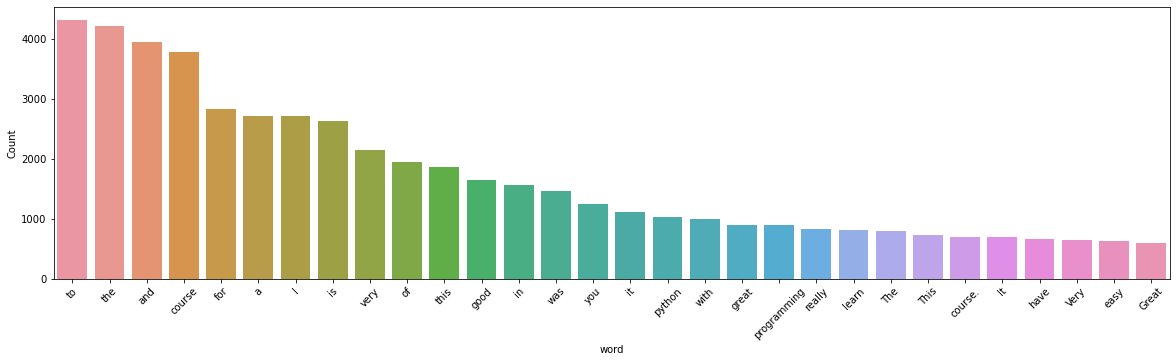

In [47]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [48]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3     professor's explanations are clear like crystal.
4    there are some cute moments that make you smil...
Name: preprocessed, dtype: object

In [49]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3       professors explanations are clear like crystal
4     there are some cute moments that make you smile 
Name: preprocessed, dtype: object

In [50]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    course beginners enjoy learn well dr chuck mad...
1                                               thanks
2            super easy totally beginners course title
3                professors explanations clear crystal
4                              cute moments make smile
Name: preprocessed, dtype: object

In [51]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

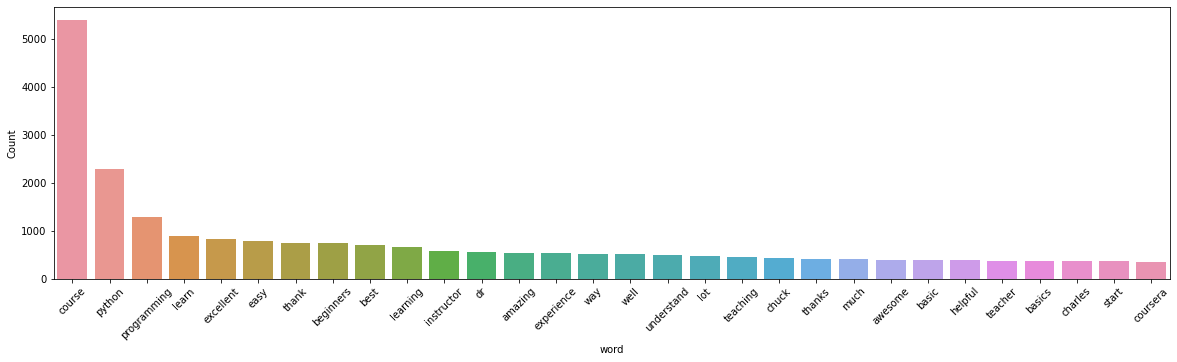

In [52]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [53]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, beginners, enjoy, learn, well, dr, ch...
1                                             [thanks]
2     [super, easy, totally, beginners, course, title]
3           [professors, explanations, clear, crystal]
4                         [cute, moments, make, smile]
Name: preprocessed, dtype: object

In [54]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (beginners, NNS), (enjoy, VBP),...
1                                      [(thanks, NNS)]
2    [(super, JJ), (easy, JJ), (totally, RB), (begi...
3    [(professors, NNS), (explanations, NNS), (clea...
4    [(cute, JJ), (moments, NNS), (make, VBP), (smi...
Name: preprocessed, dtype: object

In [55]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [56]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (beginners, n), (enjoy, v), (lea...
1                                        [(thanks, n)]
2    [(super, a), (easy, a), (totally, r), (beginne...
3    [(professors, n), (explanations, n), (clear, a...
4     [(cute, a), (moments, n), (make, v), (smile, n)]
Name: preprocessed, dtype: object

In [57]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, beginner, enjoy, learn, well, dr, chu...
1                                             [thanks]
2      [super, easy, totally, beginner, course, title]
3             [professor, explanation, clear, crystal]
4                          [cute, moment, make, smile]
Name: preprocessed, dtype: object

In [58]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

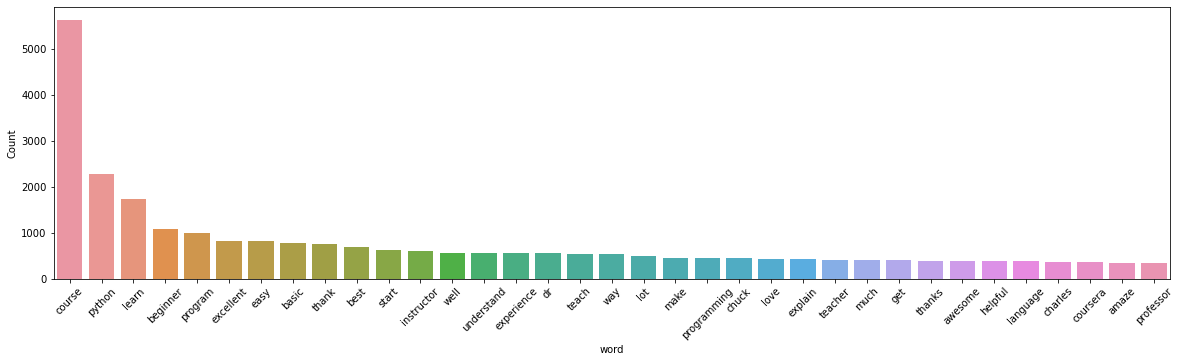

In [59]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling on a sentence-level

In [61]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [62]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [64]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [85]:
# Review

print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [77]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 5, random_state = 100,
                chunksize = 1000, passes = 50)

In [78]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.282*"course" + 0.084*"instructor" + 0.056*"love" + 0.055*"awesome" + 0.028*"first" + 0.027*"content" + 0.026*"take" + 0.026*"lecture" + 0.025*"wonderful" + 0.024*"well"

Topic: 1
Word: 0.111*"python" + 0.099*"learn" + 0.078*"course" + 0.057*"program" + 0.054*"basic" + 0.043*"start" + 0.031*"programming" + 0.029*"get" + 0.026*"language" + 0.026*"lot"

Topic: 2
Word: 0.084*"easy" + 0.060*"understand" + 0.059*"teach" + 0.058*"dr" + 0.048*"make" + 0.047*"chuck" + 0.047*"explain" + 0.046*"way" + 0.041*"teacher" + 0.038*"charles"

Topic: 3
Word: 0.162*"course" + 0.128*"beginner" + 0.083*"best" + 0.065*"experience" + 0.053*"python" + 0.042*"amaze" + 0.040*"one" + 0.036*"useful" + 0.034*"learn" + 0.025*"complete"

Topic: 4
Word: 0.145*"course" + 0.128*"excellent" + 0.114*"thank" + 0.060*"helpful" + 0.059*"much" + 0.046*"recommend" + 0.044*"enjoy" + 0.043*"want" + 0.039*"coursera" + 0.030*"python"



In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.024341  0.257309       1        1  29.611077
2     -0.449642 -0.037718       2        1  20.581750
3      0.166818  0.150445       3        1  18.369748
0      0.124471 -0.133063       4        1  16.513754
4      0.134012 -0.236973       5        1  14.923670, topic_info=          Term         Freq        Total Category  logprob  loglift
3       course  5703.000000  5703.000000  Default  30.0000  30.0000
1     beginner  1105.000000  1105.000000  Default  29.0000  29.0000
56   excellent   903.000000   903.000000  Default  28.0000  28.0000
27       thank   805.000000   805.000000  Default  27.0000  27.0000
6        learn  1673.000000  1673.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
25     drchuck    52.690335    87.832750   Topic5  -4.8929   1.3912
122      would   141.514014   248.634918   Topic5  -3.9049   1.3386
39        give    42.751940   200.735730   Topic5  -5.1019   0.3556
3       course  1022.014422  5703.265191   Topic5  -1.9278   0.1830
8       python   213.035558  2227.005494   Topic5  -3.4959  -0.4447

[212 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
191       1  0.987099        able
185       5  0.985569  absolutely
84        1  0.537391        also
84        4  0.459382        also
31        3  0.998047       amaze
...     ...       ...         ...
23        5  0.989921       world
122       1  0.213164       would
122       4  0.213164       would
122       5  0.571118       would
49        3  0.975890        zero

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

In [80]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.754927685373107

Coherence Score:  0.38296413797007667


## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [70]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [71]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

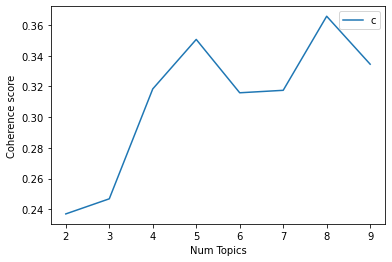

In [72]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [73]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.237
Num Topics = 3  has Coherence Value of 0.2468
Num Topics = 4  has Coherence Value of 0.3184
Num Topics = 5  has Coherence Value of 0.3506
Num Topics = 6  has Coherence Value of 0.3159
Num Topics = 7  has Coherence Value of 0.3175
Num Topics = 8  has Coherence Value of 0.3657
Num Topics = 9  has Coherence Value of 0.3345


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [74]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [76]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('teach', 0.0860990860990861),
   ('lot', 0.08064774731441399),
   ('learn', 0.0724707391374058),
   ('love', 0.0700657367324034),
   ('teacher', 0.06653839987173321),
   ('awesome', 0.06397306397306397),
   ('charles', 0.059644059644059645),
   ('fun', 0.04826038159371493),
   ('severance', 0.04537437870771204),
   ('enjoy', 0.04425204425204425)]),
 (1,
  [('easy', 0.1311292125858489),
   ('understand', 0.09103977000479156),
   ('dr', 0.0884842676888676),
   ('chuck', 0.07203322153010701),
   ('make', 0.07155406484587126),
   ('explain', 0.06963743810892829),
   ('professor', 0.05446414310812969),
   ('thing', 0.03577703242293563),
   ('coursera', 0.03226321673854017),
   ('explanation', 0.030666027791087687)]),
 (2,
  [('beginner', 0.17745371128952975),
   ('excellent', 0.12551204325741439),
   ('instructor', 0.09978699000491562),
   ('helpful', 0.0629198754710798),
   ('amaze', 0.05718499098803867),
   ('assignment', 0.04555136817958381),
   ('clear', 0.03801409143044404),
 